<a href="https://colab.research.google.com/github/MasahiroAraki/MachineLearning/blob/master/Python/chap09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第9章 深層学習

ディープニューラルネットワークを用いて識別問題をコーディングします。Google ColabでGPUを使用するときは、「ランタイム」->「ランタイムのタイプを変更」-> ハードウェアアクセラレータ -> GPU を選びます。


深層学習用ラッパーライブラリ Keras は、ver3.0 からバックエンドとして TensorFlow, JAX, PyTorch が選べるマルチバックエンドになります。この notebook では、その pre-release である [Keras Core](https://github.com/keras-team/keras-core) でコーディングを行います。

事前のインストール

In [1]:
!pip install keras-core transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 116.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 122.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.2 MB/s eta 0:00:00


## 畳み込みネットワークによる画像認識

## 準備

必要なライブラリ等を読み込みます。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras_core as keras

Using TensorFlow backend


## データの読み込み

fasion MNISTデータ（学習用60000事例、評価用10000事例、それぞれ28x28の行列）を使います。

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step       
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       


In [4]:
# 正解ラベル
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot']

<Figure size 640x480 with 0 Axes>

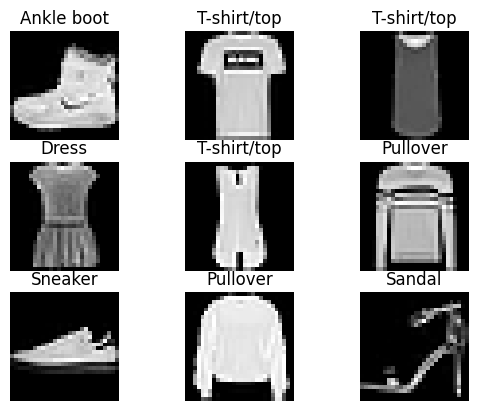

In [5]:
# いくつかの画像を表示
plt.gray()
fig, axs = plt.subplots(3, 3)
for i in range(3):
  for j in range(3):
    axs[i,j].axis("off")
    axs[i,j].set_title(class_names[y_train[i*3+j]])
    axs[i,j].imshow(X_train[i*3+j])

入力を3次元テンソルから4次元テンソルに変換します。各次元は、データ数、縦のピクセル数、横のピクセル数、チャネル数（グレースケール画像は1）を表します。

In [6]:
X_train = X_train.reshape(X_train.shape[0] , 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

値のとりうる範囲を0-255から0-1に変換します。

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

まず、通常の3階層ネットワークで学習・評価します。

In [8]:
model1 = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ flatten (Flatten)                  │ (None, 784)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense (Dense)                      │ (None, 128)                   │     100,480 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 10)                    │       1,290 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

損失関数の `sparse_categorical_crossentropy` は正解ラベルが整数で与えられているときに用います。one-hotベクトルで与えられている場合は `categorical_crossentropy`です。

In [9]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

学習時の各エポックで検証用データを使ったスコアがログに記録されます。`validation_split` を設定すると、学習用データの中から指定した割合に応じて検証用データが作成されます。

In [10]:
model1.fit(X_train, y_train, epochs=5, batch_size=200, validation_split=0.1)

Epoch 1/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7030 - loss: 0.8661 - val_accuracy: 0.8353 - val_loss: 0.4642
Epoch 2/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8438 - loss: 0.4489 - val_accuracy: 0.8577 - val_loss: 0.4155
Epoch 3/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8599 - loss: 0.4018 - val_accuracy: 0.8603 - val_loss: 0.3840
Epoch 4/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8697 - loss: 0.3687 - val_accuracy: 0.8650 - val_loss: 0.3689
Epoch 5/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8767 - loss: 0.3452 - val_accuracy: 0.8703 - val_loss: 0.3742


評価用データで性能を評価します

In [11]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8598 - loss: 0.3952
Test accuracy: 0.8565


畳み込みネットワークで学習します。モデルのパラメータ数で構造を確認してください。

In [12]:
model2 = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                    │ (None, 26, 26, 16)            │         160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d (MaxPooling2D)       │ (None, 13, 13, 16)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_1 (Conv2D)                  │ (None, 11, 11, 32)            │       4,640 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_1 (MaxPooling2D)     │ (None, 5, 5, 32)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_1 (Flatten)                │ (None, 800)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_2 (Dense)                    │ (None, 128)                   │     102,528 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_3 (Dense)                    │ (None, 10)                    │       1,290 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 108,618 (424.29 KB)

 Trainable params: 108,618 (424.29 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
model2.fit(X_train, y_train, epochs=5, batch_size=200, validation_split=0.1)

Epoch 1/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6415 - loss: 1.0175 - val_accuracy: 0.8338 - val_loss: 0.4583
Epoch 2/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8412 - loss: 0.4317 - val_accuracy: 0.8623 - val_loss: 0.3815
Epoch 3/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8628 - loss: 0.3788 - val_accuracy: 0.8653 - val_loss: 0.3632
Epoch 4/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8786 - loss: 0.3378 - val_accuracy: 0.8747 - val_loss: 0.3392
Epoch 5/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8860 - loss: 0.3142 - val_accuracy: 0.8813 - val_loss: 0.3252


In [15]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8729 - loss: 0.3493
Test accuracy: 0.8726


Dropoutを入れます。ユニットの半数が消えている状態で学習を行うので、epochは倍の回数をとります。

In [16]:
model3 = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                  │ (None, 26, 26, 16)            │         160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_2 (MaxPooling2D)     │ (None, 13, 13, 16)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_3 (Conv2D)                  │ (None, 11, 11, 32)            │       4,640 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_3 (MaxPooling2D)     │ (None, 5, 5, 32)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 5, 5, 32)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_2 (Flatten)                │ (None, 800)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_4 (Dense)                    │ (None, 128)                   │     102,528 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_1 (Dropout)                │ (None, 128)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_5 (Dense)                    │ (None, 10)                    │       1,290 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 108,618 (424.29 KB)

 Trainable params: 108,618 (424.29 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.1)

Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5735 - loss: 1.2161 - val_accuracy: 0.8150 - val_loss: 0.4824
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7925 - loss: 0.5617 - val_accuracy: 0.8415 - val_loss: 0.4126
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8214 - loss: 0.4884 - val_accuracy: 0.8545 - val_loss: 0.3818
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8325 - loss: 0.4575 - val_accuracy: 0.8698 - val_loss: 0.3498
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8463 - loss: 0.4218 - val_accuracy: 0.8743 - val_loss: 0.3375
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8517 - loss: 0.4081 - val_accuracy: 0.8790 - val_loss: 0.3241
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8588 - loss: 0.3934 - val_accuracy: 0.8878 - val_loss: 0.3047
Epoch 8/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8624 - loss: 0.3765 - val_accuracy: 0.

評価用データで評価します。

In [18]:
test_loss, test_acc = model3.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8902 - loss: 0.3040
Test accuracy: 0.8877


## リカレントニューラルネットワークによる自然言語処理

IMDBデータは映画のレビューに対して、P/N(肯定/否定)のラベルが付いた学習データです。学習用に25000事例、評価用に25000事例用意されていて、PNの割合はそれぞれ50%です。
各レビューは単語列ではなく、単語インデックスの系列として表現されています。

ここでは、頻度上位10000語を対象とし、データの大きさは先頭の50単語に限定します。

## 準備

必要なライブラリ等を読み込みます。

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import keras_core as keras

In [20]:
max_features = 10000
maxlen = 50
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


単語インデックスを単語に戻して、元のデータを確認します。インデックスは"padding", "start of sequence","unknown"にそれぞれ0,1,2が割り当てられているので、3つずらして対応させます。

In [21]:
word_index = keras.datasets.imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in X_train[0]])
decoded_review

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       


"grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

単純なRNNを構成して学習させます。

In [22]:
model1 = keras.Sequential([
    keras.layers.Input(shape=(50,)),
    keras.layers.Embedding(max_features, 128),
    keras.layers.SimpleRNN(64),
    keras.layers.Dense(1, activation='sigmoid')
])
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding (Embedding)              │ (None, 50, 128)               │   1,280,000 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ simple_rnn (SimpleRNN)             │ (None, 64)                    │      12,352 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_6 (Dense)                    │ (None, 1)                     │          65 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 1,292,417 (4.93 MB)

 Trainable params: 1,292,417 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model1.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

Epoch 1/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - acc: 0.6732 - loss: 0.5798 - val_acc: 0.8010 - val_loss: 0.4433
Epoch 2/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - acc: 0.8723 - loss: 0.3087 - val_acc: 0.7666 - val_loss: 0.5004


In [24]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.7581 - loss: 0.5025
Test accuracy: 0.7608


双方向LSTMを試します。

In [25]:
model2 = keras.Sequential([
    keras.layers.Input(shape=(50,)),
    keras.layers.Embedding(max_features, 128),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)            │ (None, 50, 128)               │   1,280,000 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bidirectional (Bidirectional)      │ (None, 128)                   │      98,816 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_7 (Dense)                    │ (None, 1)                     │         129 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model2.fit(X_train, y_train, epochs=2, batch_size=32,validation_split=0.1)

Epoch 1/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - acc: 0.7100 - loss: 0.5314 - val_acc: 0.8010 - val_loss: 0.3966
Epoch 2/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - acc: 0.8758 - loss: 0.2990 - val_acc: 0.8034 - val_loss: 0.4198


In [27]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - acc: 0.8116 - loss: 0.4188
Test accuracy: 0.8157


## 事前学習モデルを用いた識別

transformersライブラリを用いて、BERTでPN判定を行います。pipelineインスタンス作成時にタスクを与えると、デフォルトの設定が適用されます。また、モデルを与えると、そのモデルの設定が適用されます。あとは、そのインスタンスに入力を与えるだけで、結果が返却されます。

In [28]:
from transformers import pipeline

nlp = pipeline('sentiment-analysis')

sentences = [
    "I love this movie, it's amazing and I had a great time.",  # ポジティブな文
    "I am having a bad experience with this story. It's borning." # ネガティブな文
]

for sentence in sentences:
    result = nlp(sentence)
    print(f"Text: {sentence}")
    print(f"Sentiment: {result}\n")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Text: I love this movie, it's amazing and I had a great time.
Sentiment: [{'label': 'POSITIVE', 'score': 0.9998825788497925}]

Text: I am having a bad experience with this story. It's borning.
Sentiment: [{'label': 'NEGATIVE', 'score': 0.9997226595878601}]



## 練習問題

1. 畳み込みネットワークにおいて、使用するデータをCIFER10 (https://keras.io/ja/datasets/) に変更し、いくつかのネットワーク構造について認識・評価を行ってください。

1. リカレントニューラルネットワークにおいて、使用するデータを[ロイターのニュースワイヤー](https://keras.io/api/datasets/reuters/)に変更し、いくつかのネットワーク構造について認識・評価を行ってください。

1. 事前学習モデルを使って、日本語の感情分析を行ってください。

### 練習問題1の解答例



## 準備

必要なライブラリ等を読み込みます。

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import keras_core as keras

CIFER10は画像認識用のデータセットです。10種類のカテゴリの画像が含まれています。

In [64]:
cf10 = keras.datasets.cifar10
(X_train,y_train),(X_test,y_test)=keras.datasets.cifar10.load_data()

学習用データは50000枚の32x32画像で、カラーなので3チャンネルからなります。

In [65]:
X_train.shape

(50000, 32, 32, 3)

In [66]:
target_names =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

学習用データからランダムに25枚を表示します。

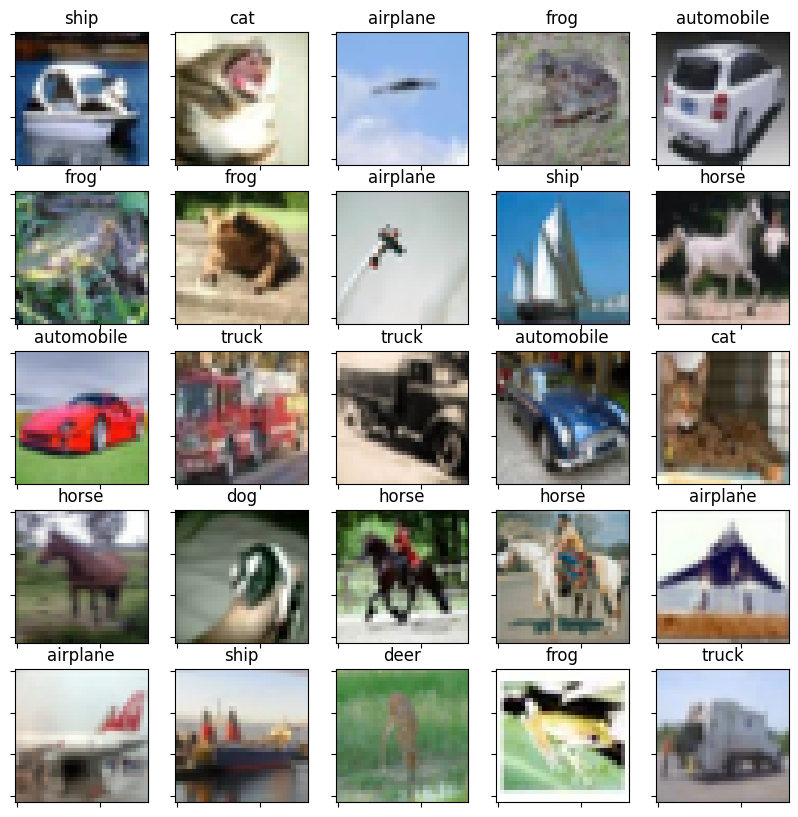

In [67]:
plt.figure(figsize=(10,10))
for i in range(25):
    rand_num = np.random.randint(0,X_train.shape[0])
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[rand_num])
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.title(target_names[y_train[rand_num][0]])
plt.show()

入力値を0～1に、出力をone-hotベクトルにします。

In [68]:
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

単純なCNNで認識してみます。

In [69]:
model1 = keras.Sequential([
    keras.layers.Input(shape=(32, 32, 3)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model1.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                  │ (None, 30, 30, 32)            │         896 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_8 (MaxPooling2D)     │ (None, 15, 15, 32)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_9 (Conv2D)                  │ (None, 13, 13, 32)            │       9,248 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_9 (MaxPooling2D)     │ (None, 6, 6, 32)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_5 (Flatten)                │ (None, 1152)                  │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_16 (Dense)                   │ (None, 128)                   │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_17 (Dense)                   │ (None, 10)                    │       1,290 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 159,018 (621.16 KB)

 Trainable params: 159,018 (621.16 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
model1.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3248 - loss: 1.8570 - val_accuracy: 0.5106 - val_loss: 1.4007
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5234 - loss: 1.3450 - val_accuracy: 0.5598 - val_loss: 1.2531
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5830 - loss: 1.1938 - val_accuracy: 0.5982 - val_loss: 1.1787
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6113 - loss: 1.1131 - val_accuracy: 0.6356 - val_loss: 1.0823
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6378 - loss: 1.0412 - val_accuracy: 0.6488 - val_loss: 1.0408


In [72]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6362 - loss: 1.0441
Test accuracy: 0.6353999972343445


バッチ標準化とドロップアウトを入れてみます。ドロップアウトでは半数のユニットが消えているので、epochは倍の回数をとります。

In [78]:
model2 = keras.Sequential([
    keras.layers.Input(shape=(32, 32, 3)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model2.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                 │ (None, 30, 30, 32)            │         896 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_14 (MaxPooling2D)    │ (None, 15, 15, 32)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_5 (Dropout)                │ (None, 15, 15, 32)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_3              │ (None, 15, 15, 32)            │         128 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_15 (Conv2D)                 │ (None, 13, 13, 32)            │       9,248 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_15 (MaxPooling2D)    │ (None, 6, 6, 32)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_8 (Flatten)                │ (None, 1152)                  │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_22 (Dense)                   │ (None, 128)                   │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_23 (Dense)                   │ (None, 10)                    │       1,290 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 159,146 (621.66 KB)

 Trainable params: 159,082 (621.41 KB)

 Non-trainable params: 64 (256.00 B)

In [79]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.1)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2669 - loss: 2.0628 - val_accuracy: 0.3174 - val_loss: 1.9686
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4634 - loss: 1.4747 - val_accuracy: 0.4758 - val_loss: 1.5680
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5131 - loss: 1.3470 - val_accuracy: 0.4044 - val_loss: 1.5971
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5422 - loss: 1.2763 - val_accuracy: 0.5738 - val_loss: 1.2242
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5663 - loss: 1.2181 - val_accuracy: 0.5838 - val_loss: 1.1918
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5862 - loss: 1.1676 - val_accuracy: 0.6038 - val_loss: 1.1320
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5976 - loss: 1.1271 - val_accuracy: 0.6012 - val_loss: 1.1356
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6128 - loss: 1.0884 - val_accuracy: 0.

In [80]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6280 - loss: 1.0717
Test accuracy: 0.6248999834060669


### 練習問題2の解答例


## 準備

必要なライブラリ等を読み込みます。

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import keras_core as keras

In [54]:
max_features = 10000
maxlen = 50
(X_train, y_train), (X_test, y_test) = keras.datasets.reuters.load_data(num_words=max_features)
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

単語インデックスを単語に戻して、元のデータを確認します。インデックスは"padding", "start of sequence","unknown"にそれぞれ0,1,2が割り当てられているので、3つずらして対応させます。

In [55]:
word_index = keras.datasets.reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in X_train[0]])
decoded_review

'company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [56]:
y_train = keras.utils.to_categorical(y_train, 46)
y_test = keras.utils.to_categorical(y_test, 46)

単純なRNNを構成して学習させます。

In [57]:
model3 = keras.Sequential([
    keras.layers.Input(shape=(50,)),
    keras.layers.Embedding(max_features, 128),
    keras.layers.SimpleRNN(64),
    keras.layers.Dense(46, activation='softmax')
])
model3.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)            │ (None, 50, 128)               │   1,280,000 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ simple_rnn_2 (SimpleRNN)           │ (None, 64)                    │      12,352 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_14 (Dense)                   │ (None, 46)                    │       2,990 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 1,295,342 (4.94 MB)

 Trainable params: 1,295,342 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model3.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - acc: 0.3424 - loss: 2.6578 - val_acc: 0.3971 - val_loss: 2.2605
Epoch 2/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.4589 - loss: 2.0191 - val_acc: 0.5417 - val_loss: 1.8686
Epoch 3/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.6255 - loss: 1.5256 - val_acc: 0.5439 - val_loss: 1.8340
Epoch 4/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.7466 - loss: 1.0685 - val_acc: 0.5184 - val_loss: 1.9173
Epoch 5/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.8486 - loss: 0.6981 - val_acc: 0.5640 - val_loss: 1.9425


In [59]:
test_loss, test_acc = model3.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.5747 - loss: 1.8230
Test accuracy: 0.5672306418418884


bi-LSTMに変更します。

In [60]:
model4 = keras.Sequential([
    keras.layers.Input(shape=(50,)),
    keras.layers.Embedding(max_features, 128),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(46, activation='softmax')
])
model4.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)            │ (None, 50, 128)               │   1,280,000 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bidirectional_2 (Bidirectional)    │ (None, 128)                   │      98,816 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_15 (Dense)                   │ (None, 46)                    │       5,934 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 1,384,750 (5.28 MB)

 Trainable params: 1,384,750 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model4.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - acc: 0.4114 - loss: 2.4876 - val_acc: 0.5395 - val_loss: 1.8600
Epoch 2/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc: 0.5773 - loss: 1.6468 - val_acc: 0.5929 - val_loss: 1.6664
Epoch 3/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.6476 - loss: 1.4239 - val_acc: 0.6374 - val_loss: 1.5535
Epoch 4/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.7082 - loss: 1.1436 - val_acc: 0.6607 - val_loss: 1.4757
Epoch 5/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.7641 - loss: 0.9136 - val_acc: 0.6630 - val_loss: 1.5143


In [62]:
test_loss, test_acc = model4.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.6591 - loss: 1.4487
Test accuracy: 0.6442564725875854


### 練習問題3の回答

In [52]:
from transformers import pipeline

nlp = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

sentences = [
    "この映画は大好きで、素晴らしくて、とても楽しかった。",  # ポジティブな文
    "この物語は嫌いだ。つまらない。" # ネガティブな文
]

for sentence in sentences:
    result = nlp(sentence)
    print(f"Text: {sentence}")
    print(f"Sentiment: {result}\n")

Text: この映画は大好きで、素晴らしくて、とても楽しかった。
Sentiment: [{'label': 'positive', 'score': 0.9550613164901733}]

Text: この物語は嫌いだ。つまらない。
Sentiment: [{'label': 'negative', 'score': 0.8958941102027893}]

